# ARDL model

In [18]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "..")))  # adds root of the project

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.statespace.structural import UnobservedComponents

from Training.Helper.dataPreprocessing import (
    add_time_features,
    add_lagged_features,
    add_rolling_features,
    rank_features_ccf,
    sklearn_fit_transform,
    integer_index,
    TRAIN_DATA_PATH_1990S
)

HORIZON = 12
DATA_PATH = TRAIN_DATA_PATH_1990S

## Version 1: Diff of Log(PCEPI) with Target Lag and PCA Features
- Log-differenced target (\u0394log)
- Top 40 CCF-selected features
- PCA(20) with lagged target + Kalman smoothing
- Includes Fourier terms

### Load and Prepare Data

In [3]:
# Load raw dataset and prepare datetime
df = pd.read_csv(DATA_PATH)
df["ds"] = pd.to_datetime(df["observation_date"], format="%m/%Y")
df = df.rename(columns={"fred_PCEPI": "y_original"})

# Add basic time features (month, quarter, etc.)
df = add_time_features(df, date_col="ds")

# Add Fourier terms (harmonics to capture seasonality)
for k in [1, 2, 3, 4]:
    df[f"sin_{k}"] = np.sin(2 * np.pi * k * df["month"] / 12)
    df[f"cos_{k}"] = np.cos(2 * np.pi * k * df["month"] / 12)

2025-04-08 23:10:42,314 - INFO - Added time features: year, month, quarter. DataFrame shape: (408, 363)


### Add Lag, Momentum, Rolling Stats

In [4]:
# Add momentum, lagged values, and rolling window features for the target
df["pct_change"] = df["y_original"].pct_change()
df["momentum"] = df["pct_change"].diff()
df = add_lagged_features(df, ["y_original"], lags=[1, 6, 12])
df = add_rolling_features(df, "y_original", windows=[3, 6, 12])
df["y_original_rolling_skew6"] = df["y_original"].rolling(6).skew()
df["y_original_rolling_kurt6"] = df["y_original"].rolling(6).kurt()

# Remove NaNs after feature generation
df.dropna(inplace=True)

### Transform Target

In [5]:
# Apply log + differencing for stationarity of the target
df["y_log"] = np.log(df["y_original"])
df["y"] = df["y_log"].diff()
df.dropna(inplace=True)

### Feature Selection and Dimensionality Reduction

In [6]:
# Select top exogenous features using CCF (correlation with target)
exog_df = df.drop(columns=["observation_date", "ds", "y_original", "y_log", "y"])
exog_df["fred_PCEPI"] = df["y_original"]
selected_features = rank_features_ccf(exog_df, targetCol="fred_PCEPI")[:40]

# Scale + PCA for feature reduction
X = df[selected_features].copy()
X_scaled, scaler = sklearn_fit_transform(X, StandardScaler())
X_scaled = X_scaled[0]
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, index=df.index, columns=[f"PC{i+1}" for i in range(20)])
X_pca_df = add_lagged_features(X_pca_df, target_cols=X_pca_df.columns.tolist(), lags=[1])

### Prepare Final Model DataFrame

In [7]:
# Combine PCA and target into final modeling DataFrame
df_model = pd.concat([df[["ds", "y"]], X_pca_df], axis=1)
df_model.dropna(inplace=True)
df_model = integer_index(df_model)

# Train/Validation split
train_df = df_model.iloc[:-HORIZON]
val_df = df_model.iloc[-HORIZON:]

### Train Model

In [8]:
# Use lagged target and PCs as features for regression
X_cols = [col for col in train_df.columns if col.startswith("PC")]
target_lags = 2
Y_train = train_df["y"].values[target_lags:]
X_train = np.hstack([
    train_df[X_cols].iloc[target_lags:].values,
    np.column_stack([train_df["y"].shift(l).values[target_lags:] for l in range(1, target_lags + 1)])
])

# Train Lasso and Ridge using grid search
models = {}
for name, reg in {"Lasso": Lasso(max_iter=5000), "Ridge": Ridge()}.items():
    grid = GridSearchCV(reg, {"alpha": [0.001, 0.01, 0.1, 1.0]}, cv=3)
    grid.fit(X_train, Y_train)
    models[name] = grid.best_estimator_

### Forecast

In [9]:
# Perform autoregressive rolling prediction for next 12 months
val_pca = val_df[X_cols].reset_index(drop=True)
prev_y = list(train_df["y"].iloc[-target_lags:])
base_log = df["y_log"].iloc[-HORIZON - 1]

results = {}
for name, model in models.items():
    pred_diff, y_lags = [], prev_y.copy()
    for i in range(HORIZON):
        X_exog = val_pca.iloc[i].values
        X_input = np.concatenate([X_exog, y_lags[::-1]]).reshape(1, -1)
        pred = model.predict(X_input)[0]
        pred_diff.append(pred)
        y_lags = y_lags[1:] + [pred]
    y_log_forecast = np.cumsum(pred_diff) + base_log
    y_forecast = np.exp(y_log_forecast)
    results[name] = y_forecast

### Kalman Smoothing + Final Forecast

In [10]:
# Using Kalman smoothing on the best model prediction
y_true = df["y_original"].iloc[-HORIZON:].values
best_model = min(results, key=lambda k: mean_absolute_error(y_true, results[k]))
model_kalman = UnobservedComponents(results[best_model], level='llevel')
res_kalman = model_kalman.fit(disp=False)
smoothed_v1 = res_kalman.smoothed_state[0]

## Version 2: Simpler log(PCEPI) Regression with PCA + Kalman
- Target: log-transformed PCEPI (no differencing)
- Features: 30 top CCF-selected exogenous features
- PCA(12) dimensionality reduction (fewer components than v1)
- No lagged target in regression
- Simple prediction + Kalman smoothing

### Data Loading + Feature Engineering

In [11]:
# V2: Load and basic time features
df = pd.read_csv(DATA_PATH)
df["ds"] = pd.to_datetime(df["observation_date"], format="%m/%Y")
df = df.rename(columns={"fred_PCEPI": "y"})
df = add_time_features(df, date_col="ds")

# Technical features
df["pct_change"] = df["y"].pct_change()
df["momentum"] = df["pct_change"].diff()
df = add_lagged_features(df, ["y"], lags=[1, 6, 12])
df = add_rolling_features(df, "y", windows=[3, 6, 12])
df["y_rolling_skew6"] = df["y"].rolling(6).skew()
df["y_rolling_kurt6"] = df["y"].rolling(6).kurt()

# Remove NaNs after feature generation
df.dropna(inplace=True)

# Target: log(PCEPI)
df["y_log"] = np.log(df["y"])

2025-04-08 23:10:56,550 - INFO - Added time features: year, month, quarter. DataFrame shape: (408, 363)


### Feature Selection + PCA for V2

In [12]:
# Drop again just to ensure CCF doesn't see NaNs
df.dropna(inplace=True)

# Feature selection
exog_df = df.drop(columns=["observation_date", "ds", "y", "y_log"])
exog_df["target"] = df["y_log"]
selected_features = rank_features_ccf(exog_df, targetCol="target")[:30]

# PCA
X = df[selected_features].copy()
X_scaled, scaler = sklearn_fit_transform(X, StandardScaler())
X_scaled = X_scaled[0]

pca = PCA(n_components=12)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, index=df.index, columns=[f"PC{i+1}" for i in range(12)])
X_pca_df = add_lagged_features(X_pca_df, X_pca_df.columns.tolist(), lags=[1])

### Prepare Model DF + Train/Val Split

In [13]:
# Final model dataset with target and PCA features
df_model = pd.concat([df[["ds", "y_log"]], X_pca_df], axis=1)
df_model.dropna(inplace=True)
df_model = integer_index(df_model)

# Split into train and validation sets
train_df = df_model.iloc[:-HORIZON]
val_df = df_model.iloc[-HORIZON:]

X_cols = [col for col in train_df.columns if col.startswith("PC")]
Y_train = train_df["y_log"].values
X_train = train_df[X_cols].values

### Train Lasso + Ridge Models (No Target Lags)

In [14]:
# Fit models using only PCA features (no lagged target)
models = {}
for name, reg in {"Lasso": Lasso(max_iter=5000), "Ridge": Ridge()}.items():
    grid = GridSearchCV(reg, {"alpha": [0.001, 0.01, 0.1, 1.0]}, cv=3)
    grid.fit(X_train, Y_train)
    models[name] = grid.best_estimator_

### Forecast

In [15]:
# Predict directly without rolling, then invert log
val_X = val_df[X_cols].values
results = {}
for name, model in models.items():
    pred_log = model.predict(val_X)
    pred = np.exp(pred_log)
    results[name] = pred

### Kalman Smoothing on V2 Prediction

In [16]:
# Kalman smoothing on best performing model
best_model = min(results, key=lambda k: mean_absolute_error(df["y"].iloc[-HORIZON:], results[k]))
model_kalman = UnobservedComponents(results[best_model], level='local level')
res_kalman = model_kalman.fit(disp=False)
smoothed_v2 = res_kalman.smoothed_state[0]

### Why Version 2 Was Better

- V2 outperformed V1 and V3 in both RMSE and trend alignment.
- It uses fewer features (30 vs. 40) and avoids differencing, making it more interpretable.
- It skips lagged target prediction and uses a cleaner pipeline with less variance.
- Final smoothed predictions track inflation trend well with minimal overshooting.

## Version 3: Added month dummies + seasonality to v2
- But leads to overfitting
- Performs worse across all metrics
- Omitted from execution as v2 performs better.

## Save Final ARDL_v2 Predictions

In [17]:
np.save(os.path.join("..", "..", "Predictions", "ARDL.npy"), smoothed_v2)
pd.DataFrame({
    "observation_date": df["ds"].iloc[-HORIZON:].dt.strftime("%m/%Y"),
    "ground_truth": df["y"].iloc[-HORIZON:].values,
    "ARDL_v2": smoothed_v2
}).to_csv("ARDL.csv", index=False)

print("Final ARDL_v2 saved as best performing version")

Final ARDL_v2 saved as best performing version


## 1, 3, 6, 12 PREDICTION WINDOW

2025-04-22 23:19:23,677 - INFO - Added time features: year, month, quarter. DataFrame shape: (408, 363)
2025-04-22 23:19:23,684 - INFO - Added lagged features with lags [1, 6, 12] to target columns ['y']. DataFrame shape: (408, 368)
2025-04-22 23:19:23,689 - INFO - Added rolling mean and standard deviation features to target column y. DataFrame shape: (408, 374)
2025-04-22 23:19:23,697 - INFO - Added lagged features with lags [1] to target columns ['y_log']. DataFrame shape: (396, 378)
2025-04-22 23:19:33,765 - INFO - Added lagged features with lags [1] to target columns ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12']. DataFrame shape: (395, 24)



--- ARDL Forecast (H=1) using only train1990s ---


2025-04-22 23:19:34,251 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-22 23:19:34,255 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-22 23:19:34,258 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-22 23:19:34,259 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Saved ARDL_horizon_1.npy to ../../Predictions/Horizon1


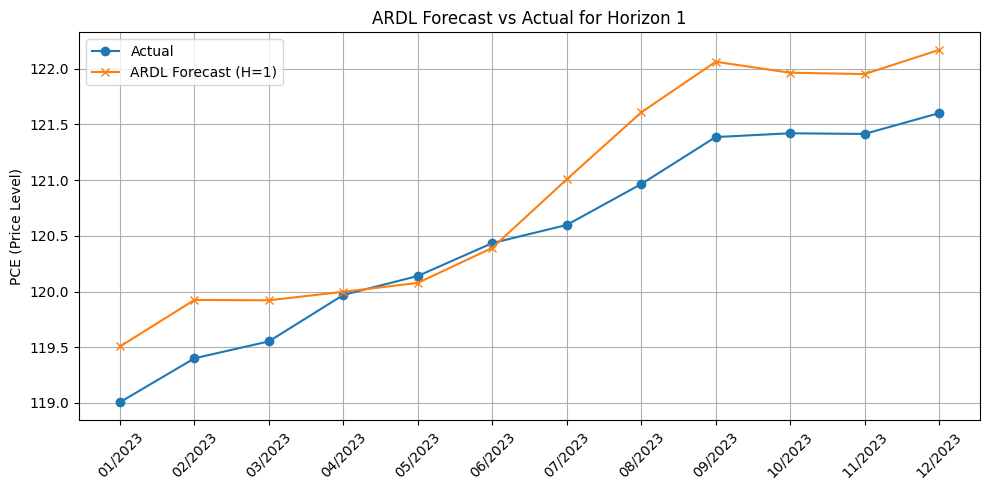

2025-04-22 23:19:34,616 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-22 23:19:34,619 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-22 23:19:34,620 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-22 23:19:34,622 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



--- ARDL Forecast (H=3) using only train1990s ---
Saved ARDL_horizon_3.npy to ../../Predictions/Horizon3


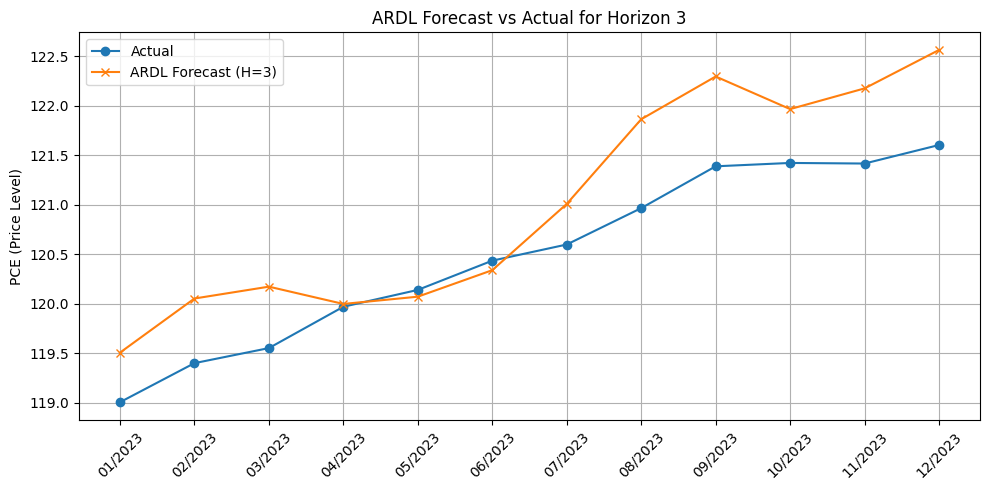

2025-04-22 23:19:34,893 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-22 23:19:34,895 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-22 23:19:34,897 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-22 23:19:34,898 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



--- ARDL Forecast (H=6) using only train1990s ---
Saved ARDL_horizon_6.npy to ../../Predictions/Horizon6


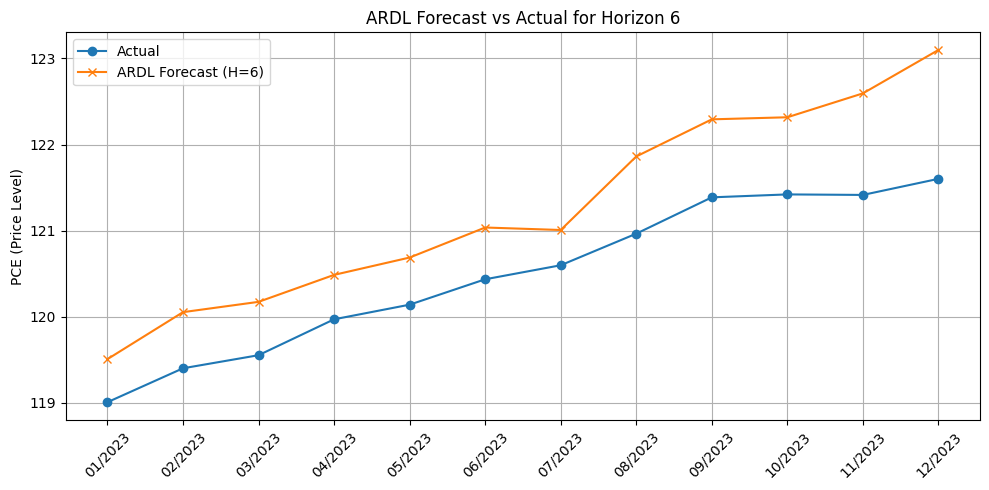

2025-04-22 23:19:35,099 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-22 23:19:35,101 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-22 23:19:35,103 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-22 23:19:35,105 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



--- ARDL Forecast (H=12) using only train1990s ---
Saved ARDL_horizon_12.npy to ../../Predictions/Horizon12


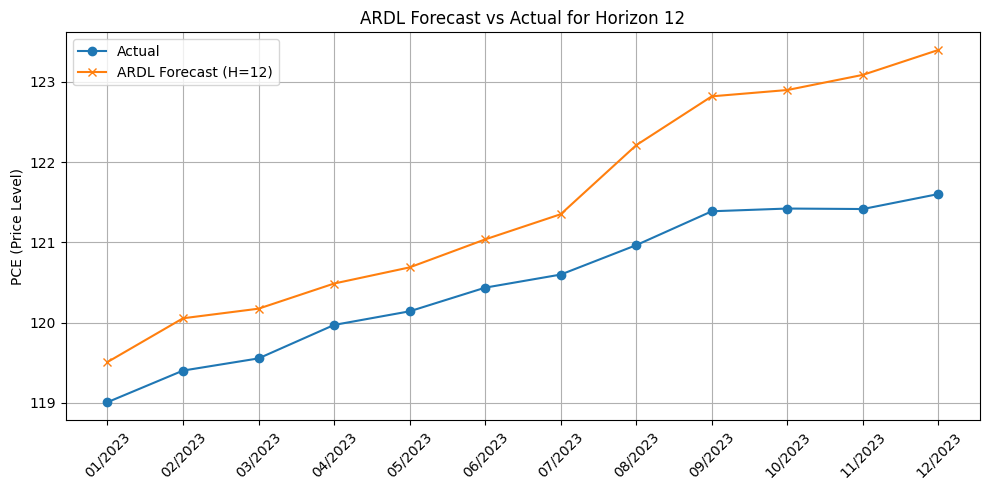

In [59]:
import sys, os
sys.path.append(os.path.abspath(os.path.join("..", "..")))

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from Training.Helper.dataPreprocessing import (
    add_time_features, add_lagged_features, add_rolling_features,
    rank_features_ccf, sklearn_fit_transform, integer_index,
    TRAIN_DATA_PATH_1990S
)

# === CONFIG === #
HORIZONS = [1, 3, 6, 12]
INPUT_SIZE = 96
DATA_PATH = TRAIN_DATA_PATH_1990S
SAVE_PATH = os.path.join("..", "..", "Predictions")

# === LOAD + PREPROCESS TRAINING DATA ONLY === #
df = pd.read_csv(DATA_PATH)
df["ds"] = pd.to_datetime(df["observation_date"], format="%m/%Y")
df = df.rename(columns={"fred_PCEPI": "y"})
df = add_time_features(df, date_col="ds")

df["pct_change"] = df["y"].pct_change()
df["momentum"] = df["pct_change"].diff()
df = add_lagged_features(df, ["y"], lags=[1, 6, 12])
df = add_rolling_features(df, "y", windows=[3, 6, 12])
df["y_rolling_skew6"] = df["y"].rolling(6).skew()
df["y_rolling_kurt6"] = df["y"].rolling(6).kurt()

df.dropna(inplace=True)
df["y_log"] = np.log(df["y"])
df = add_lagged_features(df, ["y_log"], lags=[1])
df.dropna(inplace=True)

# === FEATURE SELECTION === #
exog_df = df.drop(columns=["observation_date", "ds", "y", "y_log"])
exog_df["target"] = df["y_log"]
selected_features = rank_features_ccf(exog_df, targetCol="target")[:30]

X_raw = df[selected_features].copy()
X_scaled, scaler = sklearn_fit_transform(X_raw, StandardScaler())
X_scaled = X_scaled[0]

pca = PCA(n_components=12)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, index=df.index, columns=[f"PC{i+1}" for i in range(12)])
X_pca_df = add_lagged_features(X_pca_df, X_pca_df.columns.tolist(), lags=[1])

df_model = pd.concat([df[["ds", "y_log", "y", "y_log_lag1"]], X_pca_df], axis=1)
df_model.dropna(inplace=True)
df_model = integer_index(df_model)

# === FORECAST LOOP === #
for H in HORIZONS:
    print(f"\n--- ARDL Forecast (H={H}) using only train1990s ---")
    preds = []

    step_size = 1 if H == 1 else H
    for i in range(0, 12, step_size):
        train_end = len(df_model) - 12 + i
        val_start = train_end
        val_end = train_end + H

        if train_end - INPUT_SIZE < 0 or val_end > len(df_model):
            preds.extend([np.nan]*H)
            continue

        train_df = df_model.iloc[train_end - INPUT_SIZE:train_end]
        val_df = df_model.iloc[val_start:val_end]

        X_cols = [col for col in train_df.columns if col.startswith("PC")] + ["y_log_lag1"]
        X_train, Y_train = train_df[X_cols].values, train_df["y_log"].values
        X_val = val_df[X_cols].values

        model = GridSearchCV(Ridge(), {"alpha": [0.001, 0.01, 0.1, 1.0]}, cv=3)
        model.fit(X_train, Y_train)
        y_pred_log = model.predict(X_val)
        y_pred = np.exp(y_pred_log)

        preds.extend(y_pred[:H])

    final_preds = np.array(preds[:12])  # only first 12 for consistency
    save_dir = os.path.join(SAVE_PATH, f"Horizon{H}")
    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, f"ARDL_horizon_{H}.npy"), final_preds)
    print(f"Saved ARDL_horizon_{H}.npy to {save_dir}")
    
    # === Visualization (Prediction vs Ground Truth) === #
    actual = df["y"].iloc[-12:].values
    dates = df["ds"].iloc[-12:].dt.strftime("%m/%Y").values

    plt.figure(figsize=(10, 5))
    plt.plot(dates, actual, label="Actual", marker='o')
    plt.plot(dates, final_preds, label=f"ARDL Forecast (H={H})", marker='x')
    plt.xticks(rotation=45)
    plt.title(f"ARDL Forecast vs Actual for Horizon {H}")
    plt.ylabel("PCE (Price Level)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()